In [337]:
# the assmution is there are two cluster in a spectrogram from that we get time slices
# if the time slices with activation are in total < 50% of the lngth of recording this is sporatic
# and then we re attache the time line


In [338]:
import librosa
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa.display
BASE_FOLDER =  r'../../'
filepath = r'\dataset\min6dB\valve\id_04\normal\00000105.wav'
y, sr = librosa.load(os.path.abspath(BASE_FOLDER+filepath), sr=None, mono=False)
t = np.linspace(0,len(y[0])/sr,len(y[0]))

In [339]:
ch_stft = librosa.stft(y[0], n_fft =1024,hop_length =512, win_length = 1024)
ch_stft.shape
t_f = np.linspace(0,len(y[0])/sr,ch_stft.shape[1])

(313, 513)

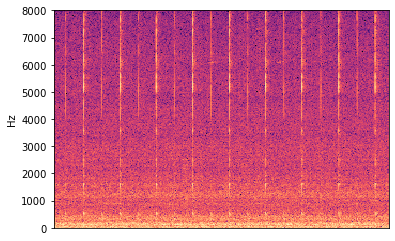

In [340]:
D = librosa.amplitude_to_db(np.abs(ch_stft), ref=np.max)

librosa.display.specshow(D, y_axis='linear',sr=sr)
D.T.shape

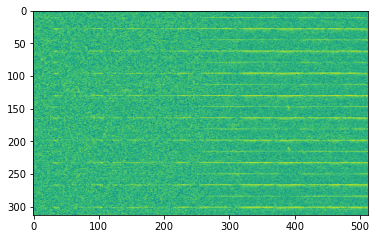

In [341]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
Dscaled = scaler.fit_transform(D.T) 
plt.imshow(Dscaled)

(160000,)

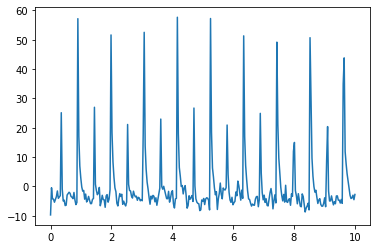

In [342]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)   
X = pca.fit_transform(Dscaled)
X.shape
plt.plot(t_f, X[:,0])
t.shape

27
[0.25641026 0.80128205 1.34615385 1.89102564 2.43589744 2.94871795
 3.52564103 4.07051282 4.61538462 5.16025641 5.70512821 6.25
 6.79487179 7.33974359 7.91666667 8.42948718 9.00641026 9.51923077]


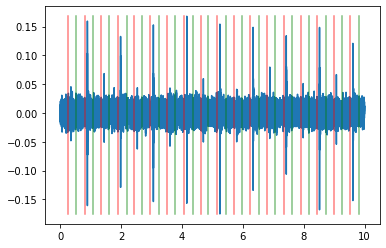

In [343]:
from sklearn.cluster import KMeans
n = 2
kmean= KMeans(n_clusters=n, max_iter=600, tol=0.001,random_state=25)
kmean.fit(X)
#for i in range(n):
#    print(t_f[np.where(kmean.labels_ == i)])


unique_elements, counts_elements = np.unique(kmean.labels_, return_counts=True)
c_on = np.argmin(counts_elements)
c_off = np.argmax(counts_elements)
print(counts_elements[c_on])
# TODO check how distrubted if even is not sporatic assumtion
# TODO chck the time windwos for energy

#ranges_s = np.zeros(counts_elements[c_on])
#ranges_e = np.zeros(counts_elements[c_on])
ranges_s = np.array([])
ranges_e = np.array([])
ii = 0
last = 0
for i in np.where(kmean.labels_==c_on)[0]:
    if i-last > 1:

        ranges_s = np.append(ranges_s,t_f[i-3])
        
        for j in np.where(kmean.labels_==c_off)[0]:
            if j>i:
                ranges_e = np.append(ranges_e,t_f[j+4])
                break
    
    last = i

print(ranges_s)
plt.plot(t,y[0])
m = [np.min(y[0]), np.max(y[0])]
for i in range(len(ranges_s)):
    
    sl = [ranges_s[i],ranges_s[i]]
    se = [ranges_e[i],ranges_e[i]]
    plt.plot(sl,m,'r',alpha=0.5)
    plt.plot(se,m,'g',alpha=0.5)
    

    


3
3


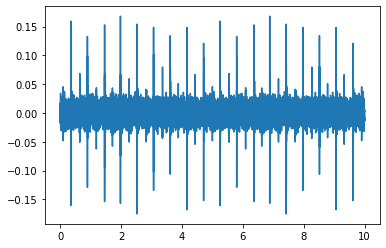

In [344]:
def time_to_index(t,sr,l):
    te=l/sr
    t_fract = t/te
    return int(l*t_fract)

# append activation
new_audio = np.array([])
noise_audio = np.array([])
last_e = 0
for a_ts, a_te in zip(ranges_s, ranges_e):
    i_s = time_to_index(a_ts,sr,len(y[0]))
    i_e = time_to_index(a_te,sr,len(y[0]))
    new_audio = np.append(new_audio, y[0][i_s:i_e])
    noise_audio = np.append(noise_audio, y[0][last_e:i_s])
    #plt.plot(new_audio)
    #plt.show()
    last_e = i_e

new_audio_app = np.array([])
r_len = int(np.ceil(len(y[0])/len(new_audio)))
print(r_len)  
for i in range(r_len):
    new_audio_app = np.append(new_audio_app, new_audio)
new_audio_app = new_audio_app[:len(y[0])]  

noise_audio_app = np.array([])
r_len = int(np.ceil(len(y[0])/len(noise_audio)))
print(r_len)  
for i in range(r_len):
    noise_audio_app = np.append(noise_audio_app, noise_audio)
noise_audio_app = noise_audio_app[:len(y[0])]  

plt.plot(t,new_audio_app)

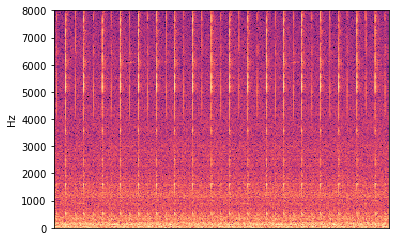

In [345]:
ch_stft = librosa.stft(new_audio_app, n_fft =1024,hop_length =512, win_length = 1024)
D = librosa.amplitude_to_db(np.abs(ch_stft), ref=np.max)

librosa.display.specshow(D, y_axis='linear',sr=sr)

In [346]:
from IPython.display import display, Markdown, Audio
display(Markdown('#### ' + 'orginal'))
display(Audio(data=y[0],rate=sr))
display(Markdown('#### ' + 'sliced'))
display(Audio(data=new_audio_app,rate=sr))
display(Markdown('#### ' + 'noise'))
display(Audio(data=noise_audio_app,rate=sr))

#### orginal

#### sliced

#### noise

# remove noise
https://timsainburg.com/noise-reduction-python.html

In [347]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa

import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal



In [348]:
output = removeNoise(audio_clip=y[0], noise_clip=noise_audio_app,verbose=False,visual=False)

[ -1.9518185  -0.9035158   1.6788573 ... -27.673376  -26.4822
 -22.742685 ] -65.604126


In [349]:
display(Markdown('#### ' + 'orginal'))
display(Audio(data=y[0],rate=sr))
display(Markdown('#### ' + 'noise adaptiv'))
display(Audio(data=output,rate=sr))

#### orginal

#### noise adaptiv

In [350]:
np.vstack(([1,2],[3,3]))

array([[1, 2],
       [3, 3]])

In [351]:
%run -i ..\..\utility\feature_extractor\TimeSliceAppendActivation.py
sliced_data = TimeSliceAppendActivation(y,sr)

load TimeSliceAppendActivation
[]


In [352]:
sliced_data.shape

(8, 160000)

In [353]:
display(Markdown('#### ' + 'orginal'))
display(Audio(data=sliced_data[0],rate=sr))

#### orginal